### Importing the Libraries

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , Embedding , Dropout , add

In [ ]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from textwrap import wrap
from string import punctuation
import os

import os
os.chdir('/kaggle/input/flickr8k/')
os.listdir()

['captions.txt', 'Images']

In [ ]:
## Read captions data
CAPTION_PATH = '/kaggle/input/flickr8k/captions.txt'
IMAGE_PATH = '/kaggle/input/flickr8k/Images'
data = pd.read_csv(CAPTION_PATH)
data.head(5)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
# To read and display Image data
def read_img(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255
    return img

def display_images(temp_df, num_images):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (8,8))
    n = 0

    for i in range(num_images):
        n += 1
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        path = IMAGE_PATH + '/' + temp_df.image[i]
        image = read_img(path)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis('off')

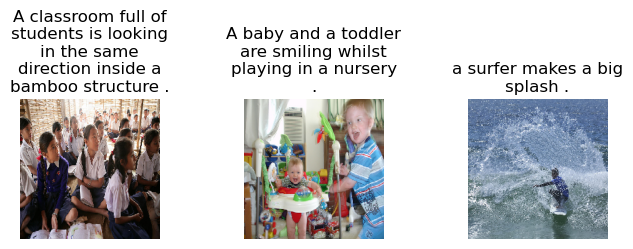

In [ ]:
display_images(data.sample(5), 3)

### Loading the Model

In [ ]:
from keras.applications import VGG16
model = VGG16(include_top=True,weights='imagenet')
## load the locally saved weights
# model.load_weights("../input/vgg16-weights-image-captioning/vgg16_weights_tf_dim_ordering_tf_kernels.h5")

In [ ]:
from keras import models
model.layers.pop()
model = models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
## show the deep learning model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Pre-Processing the images

In [ ]:
import os
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_path in tqdm(glob.glob(os.path.join(directory, '*.jpg'))):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    features[image_id] = feature

100%|██████████| 8091/8091 [49:21<00:00,  2.73it/s] 


In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 471981.12it/s]


### Pre-Processing the text

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

tokinizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize = None,
    output_sequence_length = max_length
)

tokenizer.adapt(data['captions'])

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length


35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[ke
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Building the model for prediction of the captions

In [ ]:
from keras.layers import Concatenate, Bidirectional, GRU
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2=Dense(256, activation='relu')(fe1)
dr2 = Dropout(0.4)(fe2)
fe3 = Dense(256, activation='relu')(dr2)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = Bidirectional(GRU(256))(se2)

# decoder model
decoder1 = Concatenate()([fe3, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

### Training the model

In [ ]:
import matplotlib.pyplot as plt

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# create list to store the loss values for each epoch
loss_values = []

# train the model
epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss_values.append(history.history['loss'])

227/227 [==============================] - 810s 4s/step - loss: 6.8308e-04


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

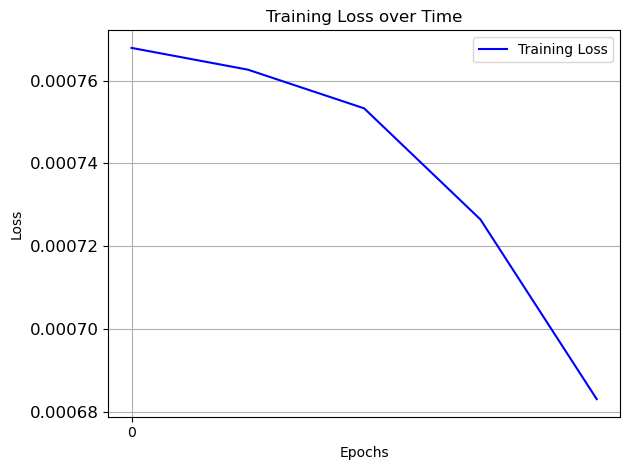

In [ ]:
# plot the loss values over time
plt.plot(loss_values, color='blue', label='Training Loss')
plt.title('Training Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, epochs, 5))
plt.yticks(fontsize=12)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

### Predicting the model

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from PIL import Image
import nltk
import matplotlib.pyplot as plt
def generate_caption(image_name):
    under_cap = []
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        under_cap.append(caption)
    true_captions = [under_cap]
    print(true_captions)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    gen_captions = [y_pred]
    print(gen_captions)
    plt.imshow(image)

---------------------Actual---------------------
[['startseq two draft horses pull cart through the snow endseq', 'startseq two golden brown horses pull sleigh driven by woman in blue coat endseq', 'startseq two horses are pulling woman in cart endseq', 'startseq two horses pull carriage driven by woman over snow covered ground endseq', 'startseq two horses pulling sled steered by smiling blond woman endseq']]
--------------------Predicted--------------------
startseq man in black dog is running in the snow endseq
['startseq man in black dog is running in the snow endseq']


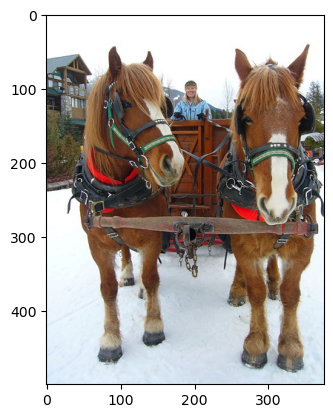

In [ ]:
generate_caption("109202801_c6381eef15.jpg")

---------------------Actual---------------------
[['startseq man in hat is displaying pictures next to skier in blue hat endseq', 'startseq man skis past another man displaying paintings in the snow endseq', 'startseq person wearing skis looking at framed pictures set up in the snow endseq', 'startseq skier looks at framed pictures in the snow next to trees endseq', 'startseq man on skis looking at artwork for sale in the snow endseq']]
--------------------Predicted--------------------
startseq man in black dog is running in the snow endseq
['startseq man in black dog is running in the snow endseq']


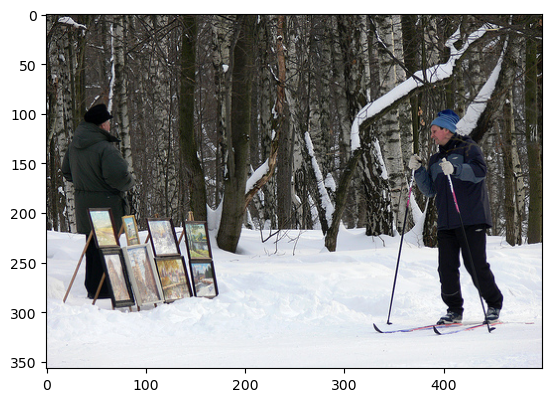

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
[['startseq black dog and brown dog playing in tall weeds endseq', 'startseq brown dog and black dog are standing against each other in some grass endseq', 'startseq two dogs are playing outside in field endseq', 'startseq two dogs play in tall grass endseq', 'startseq two dogs wrestle together in the long grass endseq']]
--------------------Predicted--------------------
startseq man in black dog is running in the snow endseq
['startseq man in black dog is running in the snow endseq']


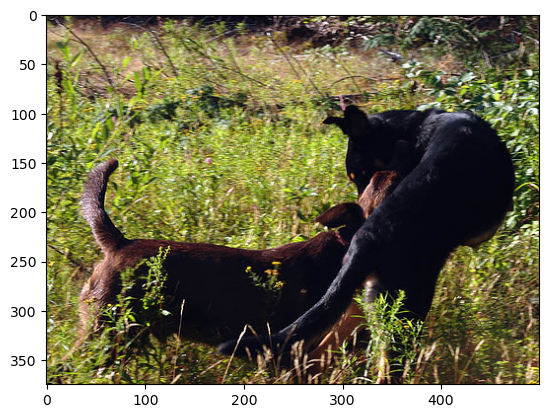

In [ ]:
generate_caption("1227655020_b11a1bb112.jpg")

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

<function __main__.generate_caption(image_name)>